<a href="https://colab.research.google.com/github/rwxhuang/lstm_vs_transformers/blob/main/Architecture_prediction_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from typing import Tuple, Union, Optional, List

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/6S898_data/"
df = pd.read_csv(DATA_PATH + "PJME_hourly.csv")
df = df.set_index('Datetime')
df.head()

Mounted at /content/drive


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [ ]:
df.index = pd.to_datetime(df.index)

# Prepare Datasets

In [ ]:
date_cutoff = df.index[int(0.75 * len(df))]
train = df.loc[df.index < date_cutoff]
test = df.loc[df.index >= date_cutoff]

sc_train = MinMaxScaler()
training_data = sc_train.fit_transform(train)

sc_test = MinMaxScaler()
test_data = sc_test.fit_transform(test)

In [ ]:
def get_dataset(to_predict, seq_length):

  def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-to_predict):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+seq_length+to_predict]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

  x, y = sliding_windows(training_data, seq_length)
  X_train, Y_train = torch.Tensor(np.array(x)), torch.Tensor(np.array(y)).flatten(1)

  x, y = sliding_windows(test_data, seq_length)
  X_test, Y_test = torch.Tensor(np.array(x)), torch.Tensor(np.array(y)).flatten(1)

  return X_train, Y_train, X_test, Y_test

# LSTM Model

## Define the LSTM Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length=10):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)

        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [ ]:
def train_model(X_train, Y_train, percent, seq_length, num_epochs=500, learning_rate=0.1):
  input_size = 1
  hidden_size = 2
  num_layers = 1

  num_classes = int(percent * seq_length)

  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

  criterion = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
  # optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      lstm.zero_grad()
      outputs = lstm(X_train)

      # obtain the loss function
      loss = criterion(outputs, Y_train)

      loss.backward()

      optimizer.step()
      if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

  now = datetime.now()
  torch.save(lstm.state_dict(), os.path.join(DATA_PATH, 'model-weights/lstm_predict_' + str(percent) + '_weights'))

## Training

In [ ]:
percents = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
seq_length = 10

In [ ]:
for percent in percents:
  to_predict = int(percent * seq_length)
  X_train, Y_train, X_test, Y_test = get_dataset(to_predict, seq_length)
  train_model(X_train, Y_train, percent, seq_length)

Epoch: 0, loss: 0.74551
Epoch: 100, loss: 0.01375
Epoch: 200, loss: 0.00140
Epoch: 300, loss: 0.00111
Epoch: 400, loss: 0.00096
Epoch: 0, loss: 0.10764
Epoch: 100, loss: 0.00175
Epoch: 200, loss: 0.00158
Epoch: 300, loss: 0.00150
Epoch: 400, loss: 0.00146
Epoch: 0, loss: 0.26428
Epoch: 100, loss: 0.01862
Epoch: 200, loss: 0.01857
Epoch: 300, loss: 0.01666
Epoch: 400, loss: 0.00310
Epoch: 0, loss: 0.16206
Epoch: 100, loss: 0.00464
Epoch: 200, loss: 0.00405
Epoch: 300, loss: 0.00326
Epoch: 400, loss: 0.00316
Epoch: 0, loss: 0.28948
Epoch: 100, loss: 0.00777
Epoch: 200, loss: 0.00614
Epoch: 300, loss: 0.00598
Epoch: 400, loss: 0.00520
Epoch: 0, loss: 0.54916
Epoch: 100, loss: 0.01209
Epoch: 200, loss: 0.00847
Epoch: 300, loss: 0.00594
Epoch: 400, loss: 0.00572
Epoch: 0, loss: 0.21812
Epoch: 100, loss: 0.00990
Epoch: 200, loss: 0.00838
Epoch: 300, loss: 0.00807
Epoch: 400, loss: 0.00757
Epoch: 0, loss: 0.37634
Epoch: 100, loss: 0.01657
Epoch: 200, loss: 0.01065
Epoch: 300, loss: 0.01013
Ep

# Evaluation

In [ ]:
def plot_result(res, test_set, variance):
  print(res.shape, test_set.shape)
  # _test = test_set.iloc[0:200].reset_index()
  # ax = _test[['PJME_MW']].plot(c='r',  figsize=(10,4))
  noisy_test = sc_train.inverse_transform(test_set)
  plt.plot(noisy_test[0:200,-1].reshape((-1,1)), c='r')
  noisy_res = sc_train.inverse_transform(res)
  plt.plot(noisy_res[0:200,-1].reshape((-1,1)), c='b')
  plt.title("Test w/Prediction Size =%.2f%% of Window Size" % (percent*100))
  plt.show()

torch.Size([35277, 1]) torch.Size([35277, 1])


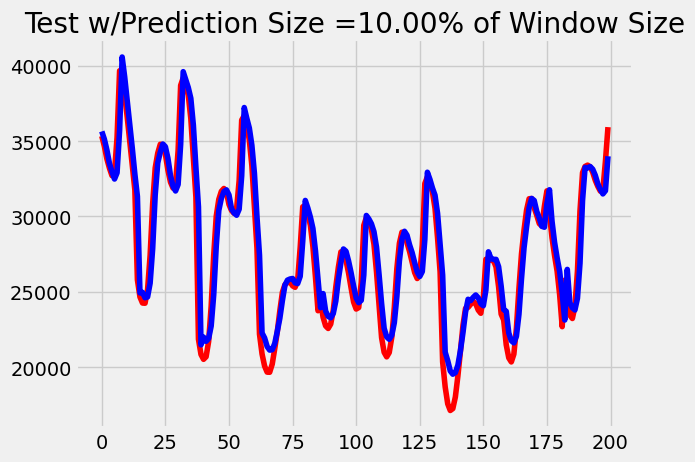

torch.Size([35276, 2]) torch.Size([35276, 2])


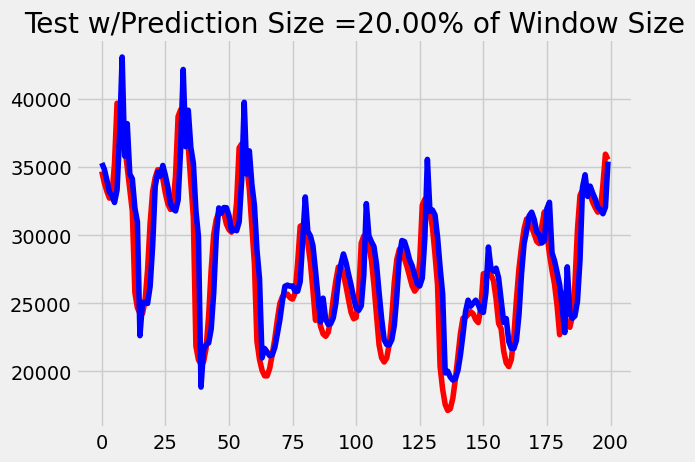

torch.Size([35275, 3]) torch.Size([35275, 3])


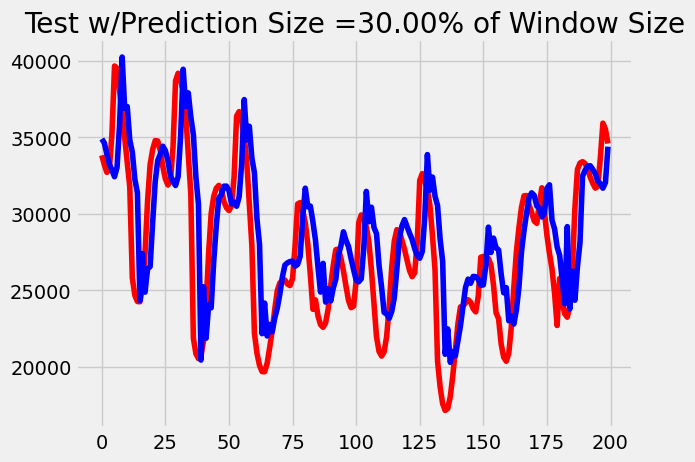

torch.Size([35274, 4]) torch.Size([35274, 4])


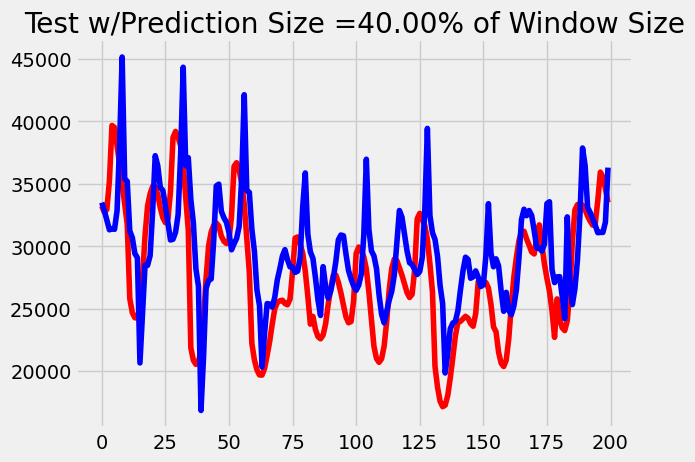

torch.Size([35273, 5]) torch.Size([35273, 5])


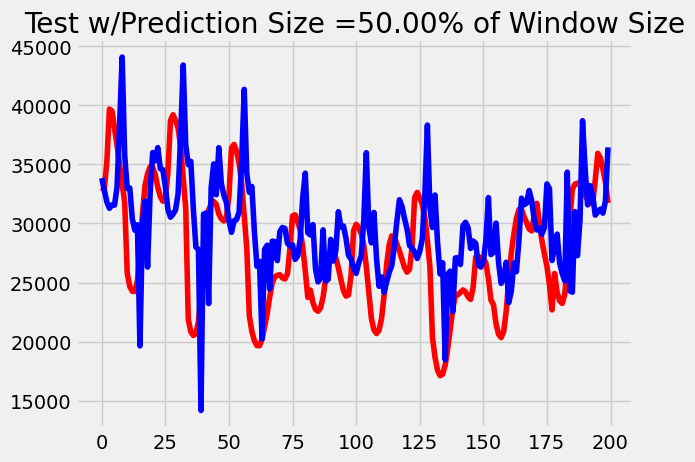

torch.Size([35272, 6]) torch.Size([35272, 6])


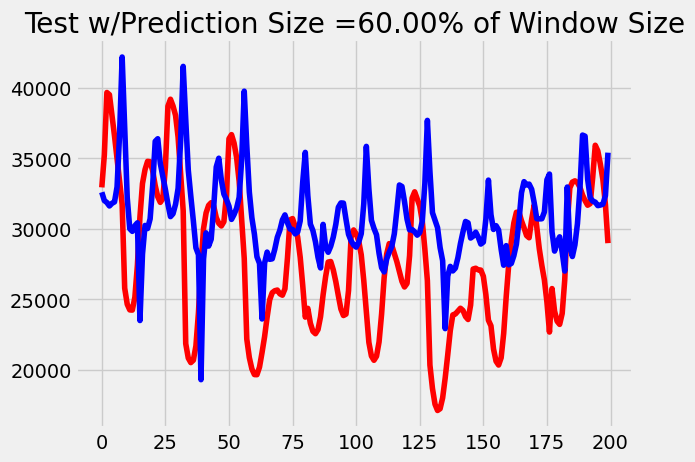

torch.Size([35271, 7]) torch.Size([35271, 7])


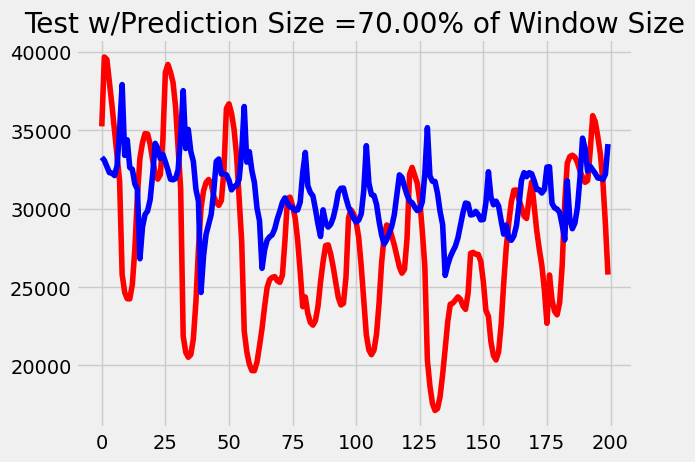

torch.Size([35270, 8]) torch.Size([35270, 8])


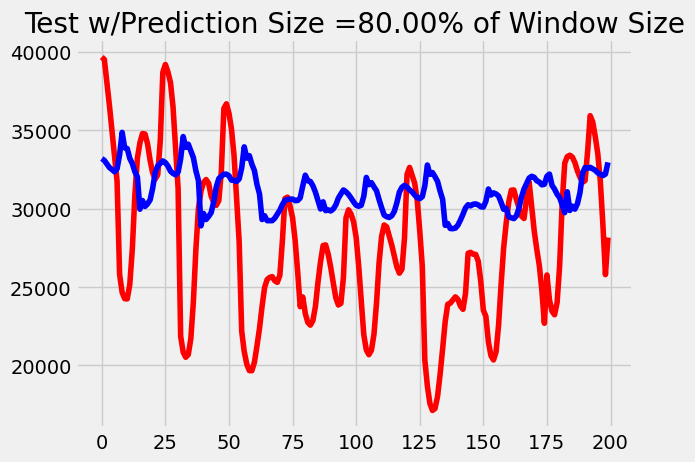

torch.Size([35269, 9]) torch.Size([35269, 9])


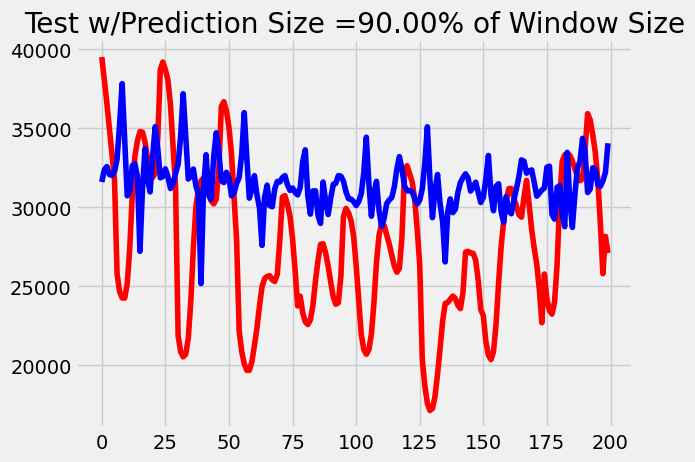

torch.Size([35268, 10]) torch.Size([35268, 10])


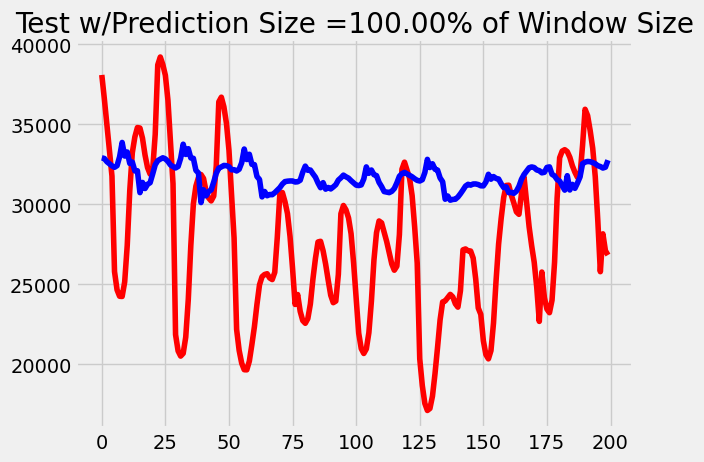

In [ ]:
#Load model from drive
input_size = 1
hidden_size = 2
num_layers = 1

losses = []

for percent in percents:
  to_predict = int(percent * seq_length)
  X_train, Y_train, X_test, Y_test = get_dataset(to_predict, seq_length)
  lstm = LSTM(to_predict, input_size, hidden_size, num_layers)
  state_dict = torch.load(DATA_PATH + 'model-weights/lstm_predict_' + str(percent) + '_weights')
  lstm.load_state_dict(state_dict)
  lstm.eval()
  with torch.no_grad():
    out = lstm(X_test)
    plot_result(out, Y_test, percent)
    losses.append(torch.nn.MSELoss()(lstm(X_test), Y_test).item())
  # print(train_predict[:10], Y_train[:10])

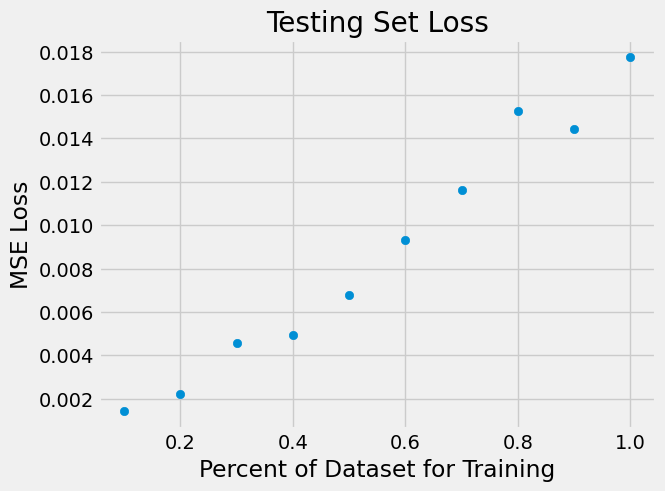

In [ ]:
plt.xlabel('Percent of Dataset for Training')
plt.ylabel('MSE Loss')
plt.title('Testing Set Loss')
plt.scatter(percents, losses)

# Transformer Model

# Define Transformer Model

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    output_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(output_shape)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

for percent in percents:
  print("Training for percent=" + str(percent))
  to_predict = int(percent * seq_length)
  X_train, Y_train, X_test, Y_test = get_dataset(to_predict, seq_length)
  model = build_model(
      input_shape,
      output_shape=to_predict,
      head_size=256,
      num_heads=4,
      ff_dim=4,
      num_transformer_blocks=4,
      mlp_units=[128],
      mlp_dropout=0.4,
      dropout=0.25,
  )

  model.compile(
      loss="mean_squared_error",
      optimizer=keras.optimizers.Adam(learning_rate=1e-4)
  )
  #model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=10, \
      restore_best_weights=True)]

  model.fit(
      X_train.numpy(),
      Y_train.numpy(),
      validation_split=0.2,
      epochs=10,
      batch_size=64,
      callbacks=callbacks,
  )

  model.save(os.path.join(DATA_PATH, 'model-weights/transformer_predict_' + str(percent) + '_weights'), save_format="h5")

Training for percent=0.8
Epoch 1/10
1376/1376 [==============================] - 268s 189ms/step - loss: 0.0473 - val_loss: 0.0120
Epoch 2/10
1376/1376 [==============================] - 259s 188ms/step - loss: 0.0132 - val_loss: 0.0075
Epoch 3/10
1376/1376 [==============================] - 278s 202ms/step - loss: 0.0093 - val_loss: 0.0064
Epoch 4/10
1376/1376 [==============================] - 279s 202ms/step - loss: 0.0078 - val_loss: 0.0058
Epoch 5/10
1376/1376 [==============================] - 280s 203ms/step - loss: 0.0069 - val_loss: 0.0055
Epoch 6/10
1376/1376 [==============================] - 259s 188ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 7/10
1376/1376 [==============================] - 254s 185ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 8/10
1376/1376 [==============================] - 256s 186ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 9/10
1376/1376 [==============================] - 277s 201ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 10/10
1376/1376

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training for percent=0.9
Epoch 1/10
1376/1376 [==============================] - 268s 190ms/step - loss: 0.0506 - val_loss: 0.0196
Epoch 2/10
1376/1376 [==============================] - 259s 188ms/step - loss: 0.0163 - val_loss: 0.0090
Epoch 3/10
1376/1376 [==============================] - 276s 201ms/step - loss: 0.0105 - val_loss: 0.0072
Epoch 4/10
1376/1376 [==============================] - 275s 200ms/step - loss: 0.0086 - val_loss: 0.0065
Epoch 5/10
1376/1376 [==============================] - 275s 200ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 6/10
1376/1376 [==============================] - 276s 200ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 7/10
1376/1376 [==============================] - 276s 200ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 8/10
1376/1376 [==============================] - 276s 201ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 9/10
1376/1376 [==============================] - 276s 201ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 10/10
1376/1376

## Evaluation

In [ ]:
percents = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

1103/1103 [==============================] - 46s 41ms/step
(35277, 1) torch.Size([35277, 1])


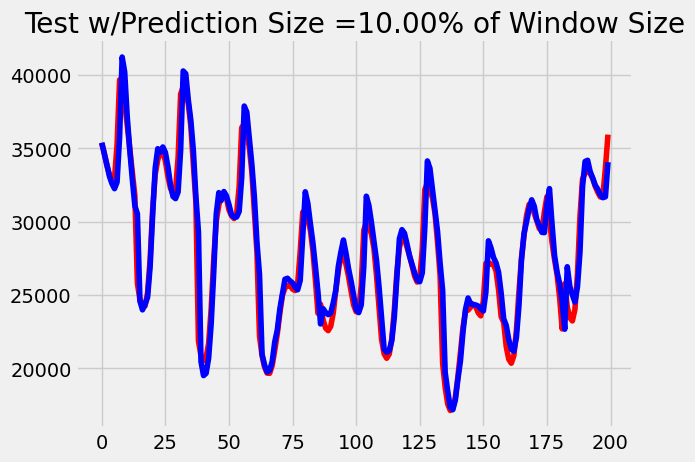

1103/1103 [==============================] - 46s 42ms/step
(35276, 2) torch.Size([35276, 2])


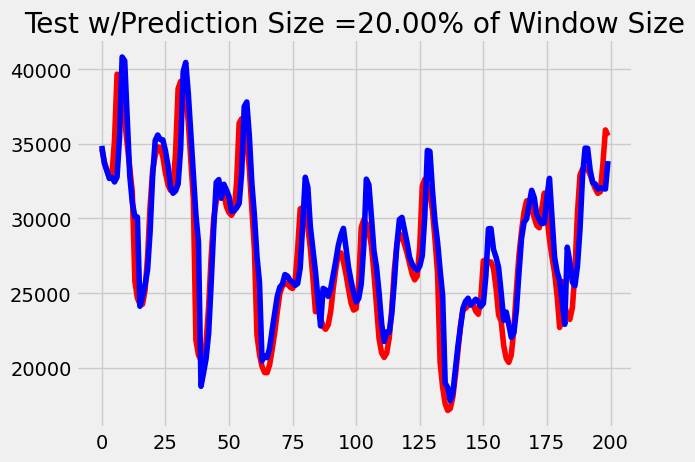

1103/1103 [==============================] - 45s 40ms/step
(35275, 3) torch.Size([35275, 3])


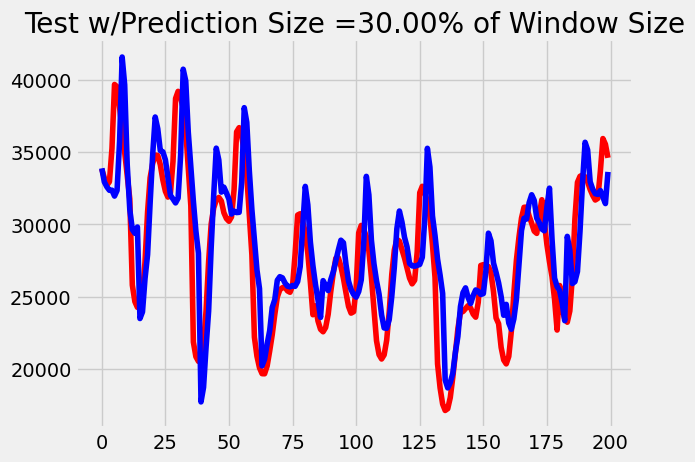

1103/1103 [==============================] - 45s 40ms/step
(35274, 4) torch.Size([35274, 4])


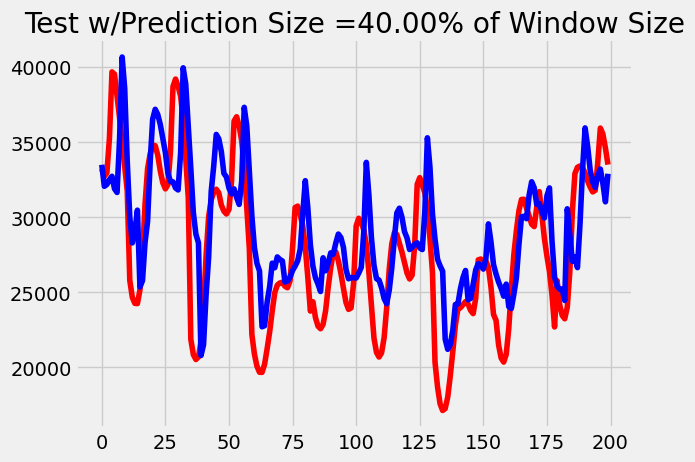

1103/1103 [==============================] - 44s 39ms/step
(35273, 5) torch.Size([35273, 5])


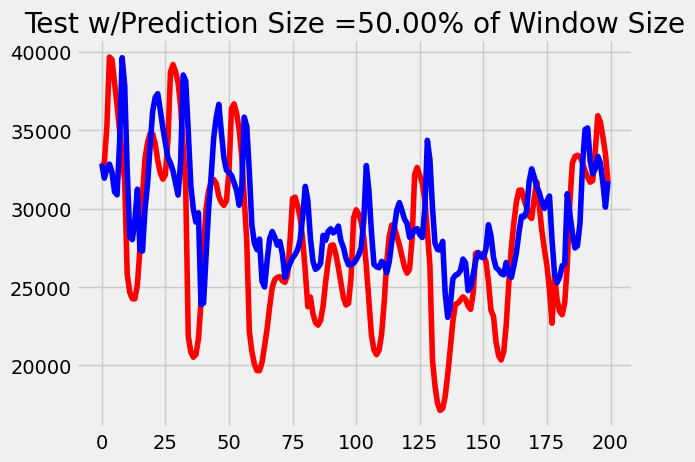

1103/1103 [==============================] - 43s 38ms/step
(35272, 6) torch.Size([35272, 6])


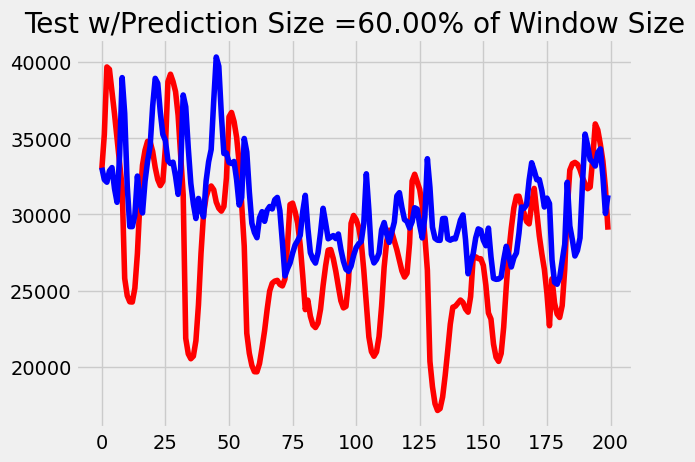

1103/1103 [==============================] - 45s 40ms/step
(35271, 7) torch.Size([35271, 7])


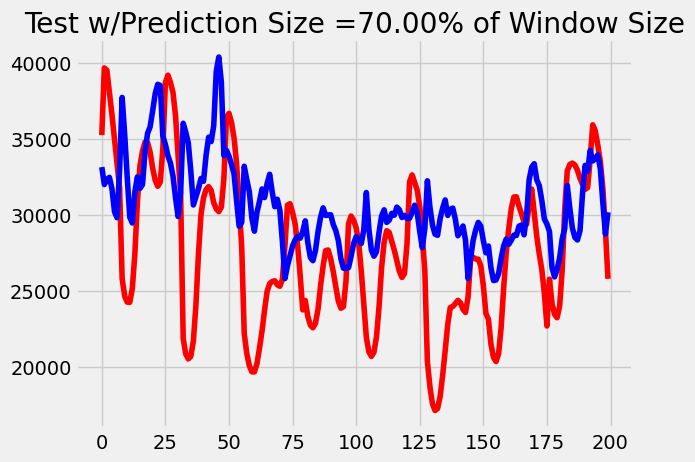

1103/1103 [==============================] - 43s 39ms/step
(35270, 8) torch.Size([35270, 8])


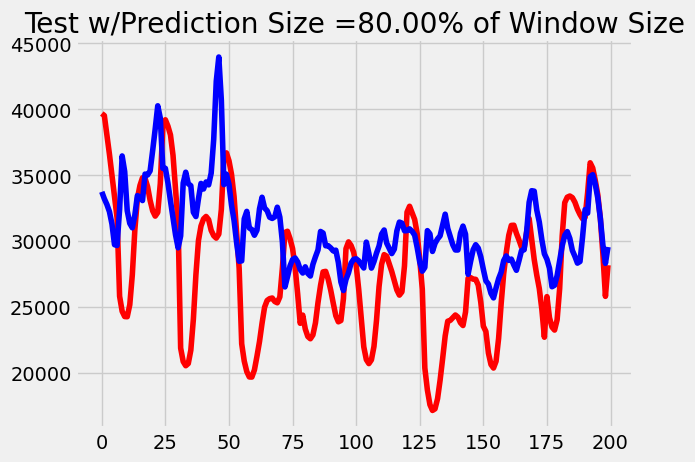

1103/1103 [==============================] - 44s 40ms/step
(35269, 9) torch.Size([35269, 9])


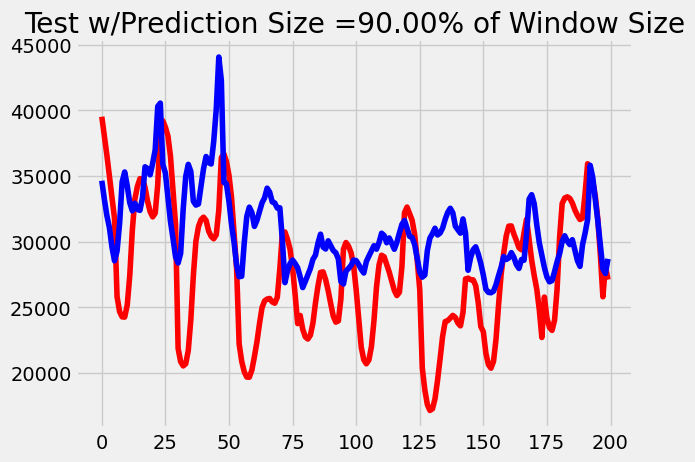

1103/1103 [==============================] - 46s 41ms/step
(35268, 10) torch.Size([35268, 10])


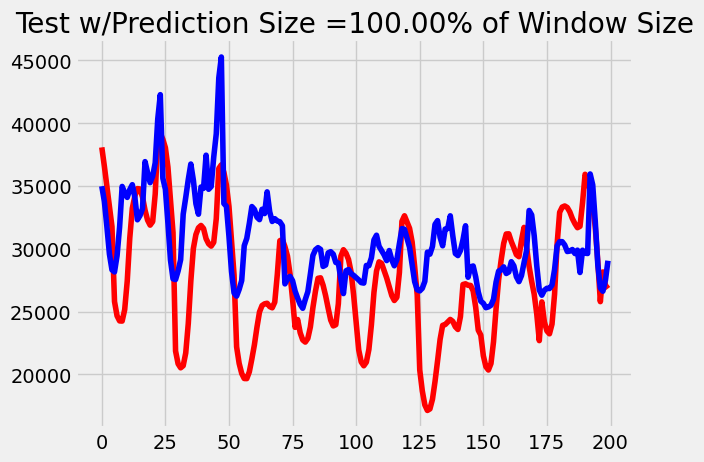

1103/1103 [==============================] - 45s 40ms/step - loss: 0.0107


[0.0007865889929234982,
 0.001693005091510713,
 0.002636647317558527,
 0.0039006622973829508,
 0.005146080162376165,
 0.007222387008368969,
 0.008326884359121323,
 0.00968997273594141,
 0.010907189920544624,
 0.010699966922402382]

In [ ]:
import tensorflow as tf
res = []
for percent in percents:
  to_predict = int(percent * seq_length)
  X_train, Y_train, X_test, Y_test = get_dataset(to_predict, seq_length)
  model = tf.keras.models.load_model(DATA_PATH + 'model-weights/transformer_predict_' + str(percent) + '_weights')
  out = model.predict(X_test.numpy())
  plot_result(out, Y_test, percent)
  res.append(model.evaluate(X_test.numpy(), Y_test.numpy()))
res

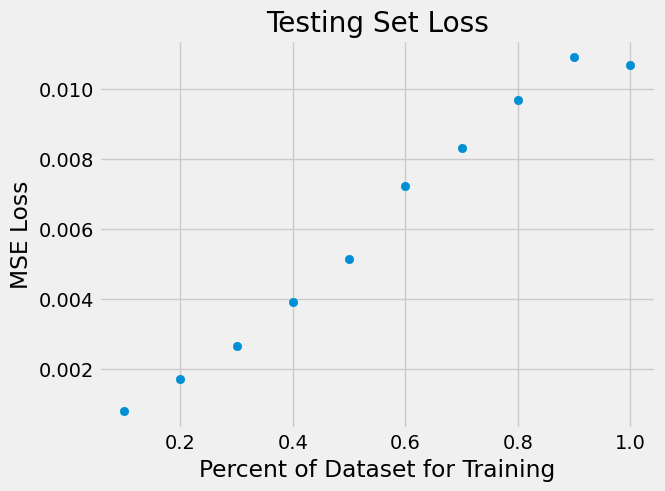

In [ ]:
plt.xlabel('Percent of Dataset for Training')
plt.ylabel('MSE Loss')
plt.title('Testing Set Loss')
plt.scatter(percents, res)

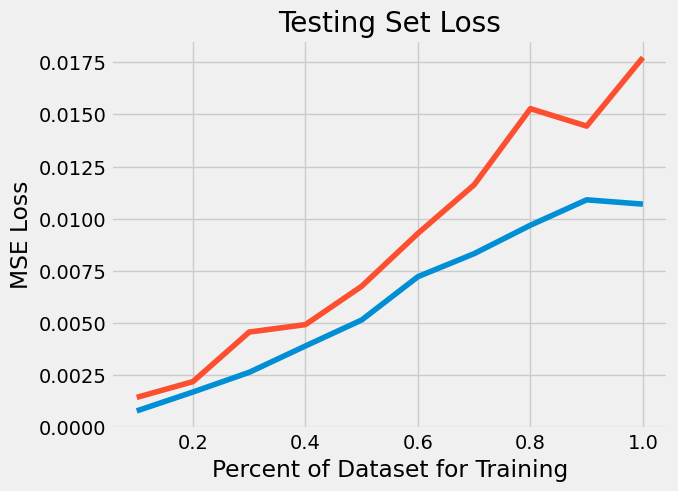

In [ ]:
plt.xlabel('Percent of Dataset for Training')
plt.ylabel('MSE Loss')
plt.title('Testing Set Loss')
plt.plot(percents, res)
plt.plot(percents, losses)